## Setup

In [3]:
!pip install transformers torch datasets
!pip install googletrans==4.0.0-rc1
!pip install dask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 8.7 MB/s eta 0:00:00


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator # use version 4.0.0-rc1
from dask import bag, diagnostics
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.flow as naf

In [36]:
import pandas as pd
import matplotlib.pyplot as plt 
import math
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [81]:
def preprocess_text(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove single quotes
    text = re.sub(r'\'', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove new lines
    text = re.sub(r'   ', ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # lower case
    text = text.lower()
    # remove stop words
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    # lemmatize
    # lemmatizer = WordNetLemmatizer()
    # text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


def load_and_preprocess_data(path, col_names):

    original_data=[]

    with open (path) as data:
        for line in data:
            original_data.append(line)
            
    print('The original data contains ', len(original_data), ' lines.')
    
    lines = []

    for line in original_data:
        elements=line.strip().split('\t')
        lines.append(elements)
    
    df = pd.DataFrame(lines, columns = col_names)

    # remove the 0-3 rows since they don't contain any data
    df = df.iloc[4:].reset_index(drop=True)

    return df

def get_ids(path):
    ids = []
    num_lines = 0
    with open(path) as f:
        for line in f:
            if num_lines == 0:
                num_lines += 1
                continue
            string = line.strip().split('\t')[0]
            ## get the number at the start of the string
            string = int(string.split(',')[0])

            ids.append(string)
    return ids

def preprocess_data(data_folder):
    pcl_cols = ["par_id", "art_id", "keyword", "country_code", "text", "label"]
    pcl_df = load_and_preprocess_data(f"{data_folder}/dontpatronizeme_pcl.tsv", pcl_cols)

    ## read txt file in the donrpatronizeme folder ignore the first line and get all the ids
    train_ids = get_ids(f"{data_folder}/train_semeval_parids-labels.txt")
    dev_ids = get_ids(f"{data_folder}/dev_semeval_parids-labels.txt")

    ## get indexes of the ids in the pcl_df

    pcl_df['label'] = pcl_df['label'].astype(int)
    pcl_df['par_id'] = pcl_df['par_id'].astype(int)

    pcl_df["class"] = pcl_df.apply(lambda x: 1 if x["label"] > 1 else 0, axis=1)
    pcl_df["text"] = pcl_df['text'].apply(lambda x: preprocess_text(x))

    ## divide into train, train_dev, dev after shuffling

    train_indexes = pcl_df[pcl_df['par_id'].isin(train_ids)].index
    dev_indexes = pcl_df[pcl_df['par_id'].isin(dev_ids)].index

    print(pcl_df.dtypes)

    train_df = pcl_df.iloc[train_indexes].reset_index(drop=True)
    dev_df = pcl_df.iloc[dev_indexes].reset_index(drop=True)

    ## divide train into train and train_dev

    train_dev_df = train_df.sample(frac=0.2, random_state=42)
    train_df = train_df.drop(train_dev_df.index).reset_index(drop=True)

    return train_df, train_dev_df, dev_df

In [82]:
def random_char_insertion(text):
    aug = nac.KeyboardAug()
    augmented_text = aug.augment(text)
    return augmented_text[0]

def random_swap(text):
    aug = naw.RandomWordAug(action="swap")
    augmented_text = aug.augment(text)
    return augmented_text[0]

def synonym_replacement(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    return augmented_text[0]

def back_translate(sequence, target_lang):

    languages = ['en', 'fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh-cn', 'hi',
                 'sw', 'vi', 'es', 'el']
    #instantiate translator
    translator = Translator()
    
    #store original language so we can convert back
    org_lang = translator.detect(sequence).lang
    print(org_lang)

    try:
        if org_lang in languages:
            #translate to new language and back to original
            translated = translator.translate(sequence, dest = target_lang).text
            #translate back to original language
            translated_back = translator.translate(translated, dest = org_lang).text
        
            output_sequence = translated_back        
        #if detected language not in our list of languages, do nothing
        else:
            output_sequence = sequence
    except:
        output_sequence = sequence
    
    return output_sequence

# Applies above define function with Dask
def back_translate_parallel(dataset, target_lang):
    dataset = dataset.copy()

    text_bag = bag.from_sequence(dataset['text'].tolist()).map(back_translate, target_lang)
    
    with diagnostics.ProgressBar():
        text_bag = text_bag.compute()

    # Add the translated to a new dataframe
    df_augmented = pd.DataFrame({"text": text_bag, "class": dataset['class']})
    return df_augmented

In [156]:
def data_augmentation(pcl_df_train_train):

    ## Back translation

    for i in range(0,600,100):
        pcl_df_train_train_aug = pcl_df_train_train[pcl_df_train_train['class'] == 1].iloc[i:i+100].copy()
        pcl_df_train_train_aug.dropna(inplace=True)
        pcl_df_train_train_aug = back_translate_parallel(pcl_df_train_train_aug, 'es')

        pcl_df_train_train_aug['class'] = 1

        pcl_df_train_train = pd.concat([pcl_df_train_train, pcl_df_train_train_aug], ignore_index=True)

    for i in range(0,600,100):
        pcl_df_train_train_aug = pcl_df_train_train[pcl_df_train_train['class'] == 1].iloc[i:i+100].copy()
        pcl_df_train_train_aug.dropna(inplace=True)
        pcl_df_train_train_aug = back_translate_parallel(pcl_df_train_train_aug, 'fr')

        pcl_df_train_train_aug['class'] = 1

        pcl_df_train_train = pd.concat([pcl_df_train_train, pcl_df_train_train_aug], ignore_index=True)   

    ## Synonym replacement 

    pcl_df_train_train_aug = pcl_df_train_train[pcl_df_train_train['class'] == 1].copy()
    pcl_df_train_train_aug['text'] = pcl_df_train_train_aug['text'].apply(lambda x: synonym_replacement(x))
    pcl_df_train_train_aug['class'] = 1

    pcl_df_train_train = pd.concat([pcl_df_train_train, pcl_df_train_train_aug], ignore_index=True)

    ## Random swap

    pcl_df_train_train_aug = pcl_df_train_train[pcl_df_train_train['class'] == 1][:400].copy()
    pcl_df_train_train_aug['text'] = pcl_df_train_train_aug['text'].apply(lambda x: random_swap(x))
    pcl_df_train_train_aug['class'] = 1

    pcl_df_train_train = pd.concat([pcl_df_train_train, pcl_df_train_train_aug], ignore_index=True)

    ## Random char insertion

    # pcl_df_train_train_aug = pcl_df_train_train[pcl_df_train_train['class'] == 1][:1000].copy()
    # pcl_df_train_train_aug['text'] = pcl_df_train_train_aug['text'].apply(lambda x: random_char_insertion(x))
    # pcl_df_train_train_aug['class'] = 1

    # pcl_df_train_train = pd.concat([pcl_df_train_train, pcl_df_train_train_aug], ignore_index=True)

    return pcl_df_train_train    

In [84]:
!ls

drive  sample_data


In [157]:
data_folder = "drive/MyDrive/NLP/dontpatronizeme_v1.4"
train_df, train_dev_df, dev_df = preprocess_data(data_folder)

pcl_df_train_train_ = train_df.copy()

pcl_df_train_train_ = data_augmentation(pcl_df_train_train_)

The original data contains  10473  lines.
par_id           int64
art_id          object
keyword         object
country_code    object
text            object
label            int64
class            int64
dtype: object
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 29.0s
[########################################] | 100% Completed | 28.3s
[########################################] | 100% Completed | 30.1s
[##################################

In [158]:
from pathlib import Path

WORKING_ENV = 'COLAB' # Can be LABS, COLAB or PAPERSPACE

assert WORKING_ENV in ['COLAB', 'PAPERSPACE']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/'
    drive.mount('/content/drive/', force_remount=True) # Outputs will be saved in your google drive

else: # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets 
    content_path = '/notebooks'

content_path = Path(content_path)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Mounted at /content/drive/


In [159]:
data_folder = f"{content_path}/NLP/data"
results_folder = f"{content_path}/NLP/results"
logging_folder = f"{content_path}/NLP/logs"

# data_folder = f"{content_path}/data"
# results_folder = f"{content_path}/results"
# logging_folder = f"{content_path}/logs"

In [14]:
import torch
from transformers import AutoTokenizer, LongformerForSequenceClassification

In [15]:
import pandas as pd
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
import torch.nn as nn
import torch
import datasets
# from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!ls

drive  sample_data


## Load data

In [160]:
pcl_df_train_train = pcl_df_train_train_
pcl_df_train_dev = train_dev_df
pcl_df_dev =dev_df
# pcl_df_dev = pcl_df_dev.dropna()

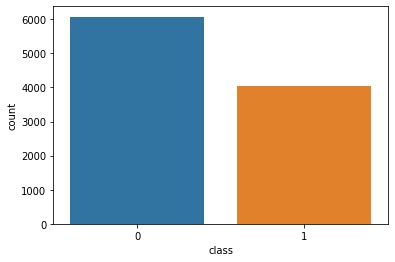

In [161]:
ax = sns.countplot(x="class", data=pcl_df_train_train)

In [ ]:
chatgpt = pd.read_csv(f"{data_folder}/chatgpt_reword_random_200samples.csv")

FileNotFoundError: ignored

In [ ]:
chatgpt["class"] = 1

NameError: ignored

In [65]:
pcl_df_train_train = pcl_df_train_train[["text", "class"]].copy()

In [ ]:
pcl_df_train_train.shape

(9525, 2)

In [ ]:
chatgpt.shape

NameError: ignored

In [ ]:
pcl_df_train_train = pd.concat([pcl_df_train_train, chatgpt], ignore_index=True)

NameError: ignored

In [ ]:
pcl_df_train_train.shape

(9525, 2)

In [ ]:
# pcl_df_train_train = pd.read_csv(f"{data_folder}/pcl_df_train_train_aug.csv")
# pcl_df_train_dev = pd.read_csv(f"{data_folder}/pcl_df_train_dev_processed.csv")
# pcl_df_dev = pd.read_csv(f"{data_folder}/pcl_df_dev_processed.csv")

In [162]:
pcl_df_train_train = pcl_df_train_train[['text', 'class']]
pcl_df_train_dev = pcl_df_train_dev[['text', 'class']]
pcl_df_dev = pcl_df_dev[['text', 'class']]

In [163]:
pcl_df_train_train = datasets.Dataset.from_pandas(pcl_df_train_train)
pcl_df_train_dev = datasets.Dataset.from_pandas(pcl_df_train_dev)
pcl_df_dev = datasets.Dataset.from_pandas(pcl_df_dev)

In [164]:
type(pcl_df_train_train)

datasets.arrow_dataset.Dataset

### DistilBERT

In [165]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [141]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [166]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [182]:
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a

In [183]:
distilbert_model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [185]:
distilbert_model.classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1)
)

### Functions for Tokenization and Metrics Calculation

In [186]:
tokenizer = distilbert_tokenizer
# define a function that will tokenize the model, and will return the relevant 
# inputs for the model
def tokenization(batched_text):
    return tokenizer(
        batched_text['text'], 
        padding = 'max_length', 
        truncation=True, 
        max_length = 512
    )

In [187]:
# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Tokenization

In [188]:
pcl_df_train_train = pcl_df_train_train.map(
    tokenization, batched = True, batch_size = len(pcl_df_train_train)
)
pcl_df_train_dev = pcl_df_train_dev.map(
    tokenization, batched = True, batch_size = len(pcl_df_train_dev)
)

pcl_df_dev = pcl_df_dev.map(
    tokenization, batched = True, batch_size = len(pcl_df_dev)
)

Map:   0%|          | 0/10125 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [190]:
pcl_df_train_train.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'class']
)
pcl_df_train_dev.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'class']
)
pcl_df_dev.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'class']
)

ValueError: ignored

In [189]:
pcl_df_train_train = pcl_df_train_train.rename_column("class", "label")
pcl_df_train_dev = pcl_df_train_dev.rename_column("class", "label")
pcl_df_dev = pcl_df_dev.rename_column("class", "label")

ValueError: ignored

### Training

In [191]:
# hyperparameters
train_batch_size = 32
eval_batch_size = 32
lr = 2e-5
num_epochs = 30
gradient_accumulation_steps = 8
warmup_steps = 200
weight_decay = 0.01
logging_steps = 4

In [192]:
training_args = TrainingArguments(
    output_dir = results_folder,
    num_train_epochs = num_epochs,
    per_device_train_batch_size = train_batch_size,
    learning_rate = lr,
    gradient_accumulation_steps = gradient_accumulation_steps,    
    per_device_eval_batch_size= eval_batch_size,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    metric_for_best_model = 'eval_f1',
    greater_is_better = True,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_steps = logging_steps,
    fp16 = True,
    logging_dir=logging_folder,
    dataloader_num_workers = 0,
    run_name = 'distilbert-classification'
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [193]:
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=pcl_df_train_train,
    eval_dataset=pcl_df_train_dev
)


Using cuda_amp half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10125
  Num Epochs = 30
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 8
  Total optimization steps = 1170
  Number of trainable parameters = 67002946


Epoch,Training Loss,Validation Loss


### Saving trained model

In [ ]:
# save the best model
trainer.save_model(f'{results_folder}/distilbert')

Saving model checkpoint to /content/drive/MyDrive/NLP/results/distilbert
Configuration saved in /content/drive/MyDrive/NLP/results/distilbert/config.json
Model weights saved in /content/drive/MyDrive/NLP/results/distilbert/pytorch_model.bin


### Load trained model

In [ ]:
trained_model = LongformerForSequenceClassification.from_pretrained(
    f'{results_folder}/distilbert',
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

loading configuration file /content/drive/MyDrive/NLP/results/distilbert/config.json
You are using a model of type distilbert to instantiate a model of type longformer. This is not supported for all configurations of models and can yield errors.
Model config LongformerConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "attention_window": 512,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "longformer",
  "n_heads": 12,
  

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 16


{'eval_loss': 0.37963035702705383,
 'eval_accuracy': 0.9385074626865672,
 'eval_f1': 0.6869300911854104,
 'eval_precision': 0.743421052631579,
 'eval_recall': 0.6384180790960452,
 'eval_runtime': 1.7938,
 'eval_samples_per_second': 933.748,
 'eval_steps_per_second': 58.533,
 'epoch': 9.99}

### Make predictions on official dev set

In [ ]:
dev_set_preds, labels, metrics = trainer.predict(
    pcl_df_dev, metric_key_prefix="dev"
)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2093
  Batch size = 16


In [ ]:
metrics

{'dev_loss': 0.4193435311317444,
 'dev_accuracy': 0.939799331103679,
 'dev_f1': 0.64,
 'dev_precision': 0.7417218543046358,
 'dev_recall': 0.5628140703517588,
 'dev_runtime': 2.4336,
 'dev_samples_per_second': 860.041,
 'dev_steps_per_second': 53.83}

In [ ]:
dev_set_preds = np.argmax(dev_set_preds)